In [1]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from natsort import natsorted

# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# change base folder to parent
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print(os.getcwd())

/mnt/C45ADD865ADD7620/i3d-rrc/ic-topo-nav/mickst3r


In [2]:
from mast3r_src.model import AsymmetricMASt3R

from dust3r_src.dust3r.inference import inference
from dust3r_src.dust3r.utils.image import load_images

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model_name = "./checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

Using device: cuda
... loading model from ./checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


In [3]:
dataset_root = Path("./data/mapfree_eval_subset")

VAL_SCENES = ["s00474", "s00482", "s00489", "s00495"]
scene_paths = [dataset_root / scene for scene in VAL_SCENES]

print(f"Found {len(scene_paths)} scenes")

scene_path = scene_paths[0]
print(f"Selected scene: {scene_path}")

reference_image_folder = scene_path / "seq0"
image_r_path = reference_image_folder / "frame_00000.jpg"

query_image_folder = scene_path / "seq1"
query_image_paths = natsorted(list(query_image_folder.glob("*.jpg")))

QUERY_NAT_IDX = 0
image_q_path = query_image_paths[QUERY_NAT_IDX]

Found 4 scenes
Selected scene: data/mapfree_eval_subset/s00474


>> Loading a list of 2 images
 - adding data/mapfree_eval_subset/s00474/seq0/frame_00000.jpg with resolution 540x720 --> 384x512
 - adding data/mapfree_eval_subset/s00474/seq1/frame_00118.jpg with resolution 540x720 --> 384x512
 (Found 2 images)


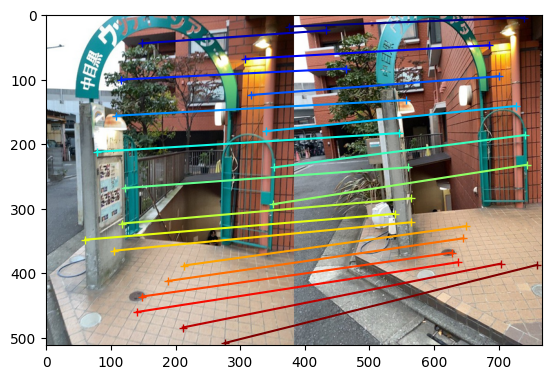

In [4]:
from mast3r_src.fast_nn import fast_reciprocal_NNs

device = 'cuda'

images = load_images([str(image_r_path), str(image_q_path)], size=512)
output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

# at this stage, you have the raw dust3r predictions
view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']

desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

# find 2D-2D matches between the two images
matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                                device=device, dist='dot', block_size=2**13)

# ignore small border around the edge
H0, W0 = view1['true_shape'][0]
valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
    matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

H1, W1 = view2['true_shape'][0]
valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
    matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

valid_matches = valid_matches_im0 & valid_matches_im1
matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

# visualize a few matches
n_viz = 20
num_matches = matches_im0.shape[0]
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

viz_imgs = []
for i, view in enumerate([view1, view2]):
    rgb_tensor = view['img'] * image_std + image_mean
    viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img = np.concatenate((img0, img1), axis=1)
plt.figure()
plt.imshow(img)
cmap = plt.get_cmap('jet')
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    plt.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
plt.show(block=True)